ANALYSE EXPLORATOIRE DES DONNÉES

In [ ]:
import pandas as pd
train_data = pd.read_csv("./train_17k_clean_fasttext_noempty.csv")
train_data = train_data.rename(columns={'label': 'generated'})
train_data = train_data.iloc[0:4000]
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  4000 non-null   int64 
 1   text        4000 non-null   object
 2   generated   4000 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 93.9+ KB


In [ ]:
train_data.head(2)

,Unnamed: 0,text,generated,lenght of text
0,0,car car around since became famous henry ford ...,0,2076
1,1,transportation large necessity country worldwi...,0,1837


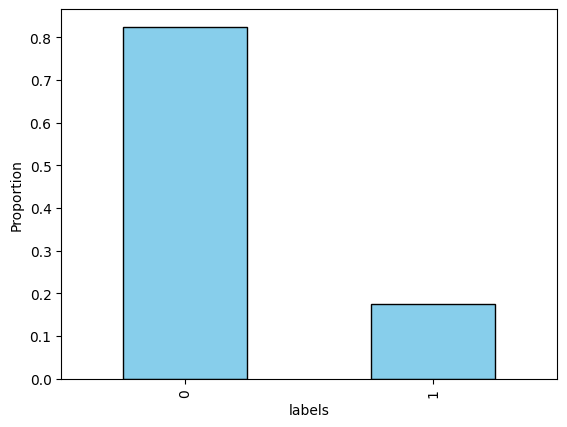

In [ ]:
import matplotlib.pyplot as plt
labels = train_data["generated"]
text = train_data["text"]
count = labels.value_counts(normalize=True)
count.plot(kind='bar',color='skyblue', edgecolor='black')
plt.xlabel('labels')
plt.ylabel('Proportion')
plt.show()



On constate que les données sont déséquilibrées dans le dataset notamment pour les textes générés par un LLM(1).

Nous allons maintenant observer les longueur des textes générés par un LLM ou un étudiant pour voir s'ils sont différents

In [ ]:
def lenght(row):
  return len(row)
train_data["lenght of text"] = train_data["text"].apply(lenght,1)
train_data.tail(10)


,Unnamed: 0,text,generated,lenght of text
3990,3990,limited car usage beneficial many way since ta...,0,625
3991,3991,artical car free city people world going carle...,0,1319
3992,3992,car large help transportation although alot de...,0,1203
3993,3993,family home car garage car ownership allowed t...,0,939
3994,3994,fellow citizen allow make urgent announcement ...,0,2362
3995,3995,past decade talk regarding car pollution usefu...,0,2219
3996,3996,advantage limitng car usage well ther cause us...,0,1766
3997,3997,car becoming dying trend world people choose w...,0,1831
3998,3998,car mostly everyone car car definetly seen car...,0,705
3999,3999,people america go day without using car countr...,0,1346


(array([  5.,   0.,   2.,   1.,  10., 150., 242., 182.,  86.,  24.]),
 array([  18. ,  372.7,  727.4, 1082.1, 1436.8, 1791.5, 2146.2, 2500.9,
        2855.6, 3210.3, 3565. ]),
 <BarContainer object of 10 artists>)

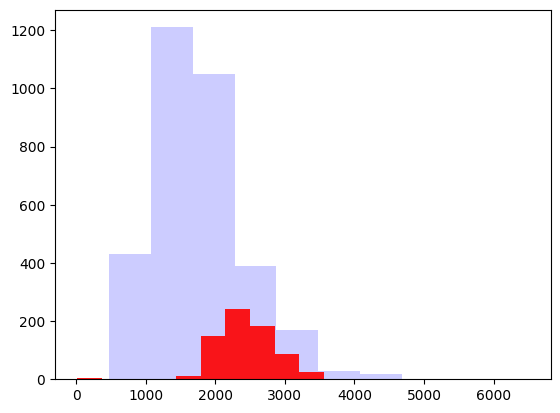

In [ ]:
bystudent = train_data[train_data["generated"]==0]["lenght of text"]
byllm = train_data[train_data["generated"]==1]["lenght of text"]
plt.hist(bystudent,alpha=0.2,color="blue")
plt.hist(byllm,alpha=0.9,color="red")

On constate que les longueurs des textes générés par les étudiants et les llms sont en général les mêmes.

# Text preprocessing

In [ ]:
import nltk

nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    |   Package bcp47 is already up-to-dat

True

## Clean the data

In [ ]:
import re

from nltk.corpus import stopwords

from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

corpus = []
k = 1
def clean(prompt):
    global k
    r = re.sub('[^a-zA-Z]', ' ', str(prompt))
    r = r.lower()
    r = r.split()
    ## we can also tokenize with nltk.tokenize et word_tokenization()
    r = [word for word in r if word not in stopwords.words('english')]
    r = [lemmatizer.lemmatize(word) for word in r]
    r = ' '.join(r)
    k+=1
    return r


# new = train_data['text'].truncate(before=1,after=20).apply(clean,1)
# new.head()


train_data['text'] = train_data['text'].apply(clean,1)
train_data['text'].tail()


17246    dear senator writing today express view electo...
17247    dear senator writing today express support abo...
17248    dear senator writing today express strong supp...
17249    dear senator writing today express strong supp...
17250    dear senator writing today express strong supp...
Name: text, dtype: object

### Embedding
On utilise des embeddings préentrainés sur de grandes volumes de données textuelles en anglais. Nous utilisons le modèle fasttext parce qu'il permet de générer des embeddings sur de mots qu'il n'a jamais vu auparavant

In [ ]:
%pip install fasttext

In [ ]:
import fasttext
Listvocab = list(train_data['text'])
with open('corpus.txt', 'w', encoding='utf-8') as file:
    for sentence in Listvocab:
        file.write(sentence + '\n')
model = fasttext.train_unsupervised('corpus.txt',dim=200,minn=2, maxn=6)
model.save_model('fasttext.bin')

In [ ]:
embedding_model = fasttext.load_model('fasttext.bin')

In [ ]:
import numpy
def get_vect(word):
    try:
      return embedding_model.get_word_vector(word)
    except KeyError:
        return numpy.zeros((model.vector_size,))

def sum_vectors(phrase):
    return sum(get_vect(w) for w in phrase)/len(phrase)

def features(X):
    feats = numpy.vstack([sum_vectors(p) for p in X])
    return feats


### Entrainement et finetuning des modèles pour maximiser l'auc.

On effectue une cross validation stratifiée pour tester nos modèles.


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import precision_score, roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.model_selection import train_test_split

X = features(train_data['text'])
Y = train_data['generated']
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3,stratify=Y,random_state=10)
cv_stratified = StratifiedKFold(5,shuffle=True)
model1 = LogisticRegression(max_iter=10000)
model2 = SVC(max_iter=10000)
model3 = RandomForestClassifier()
model4 = HistGradientBoostingClassifier(max_iter=10000)
param1 = {
          'penalty' : ['l2',None],
          'solver':['lbfgs', 'newton-cg', 'newton-cholesky', 'sag'],
          'C': [1,5,10],
          }
param2 = {
          'C': [1,5,10],
          'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
          'gamma': ['scale','auto'],
          }
param3 = {'n_estimators':[50,100,150],'criterion':['gini', 'entropy', 'log_loss'],'max_depth':[None,5,10,20],'min_samples_split':[2,5,7,10]}
param4 = {'learning_rate':[0.1,0.2,0.5],'max_depth':[None,5,10,20]}


On cherche les meilleurs hyperparamètres sur les données de validation pour chaque modèle

Logistic Regression

In [ ]:
clf1 = GridSearchCV(model1,param_grid=param1,scoring='roc_auc',n_jobs=-1,cv=cv_stratified)
clf1.fit(X_train,Y_train)
bp1 = clf1.best_params_
print(f"Meilleurs hyperparamètres: {clf1.best_params_}, Meilleure auc: {clf1.best_score_}")
rf_model1 = LogisticRegression(penalty=bp1['penalty'],solver=bp1['solver'],C=bp1['C'],max_iter=10000)


SVM

In [ ]:
clf2 = GridSearchCV(model2,param_grid=param2,scoring='roc_auc',n_jobs=-1,cv=cv_stratified)
clf2.fit(X_train,Y_train)
bp2 = clf2.best_params_
print(f"Meilleurs hyperparamètres: {clf2.best_params_}, Meilleure auc: {clf2.best_score_}")
rf_model2 = SVC(C=bp2['C'],kernel=bp2['kernel'],gamma=bp2['gamma'],max_iter=10000)


Meilleurs hyperparamètres: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}, Meilleure auc: 0.9935353916976327


Randomforest

In [ ]:
clf3 = GridSearchCV(model3,param_grid=param3,scoring='roc_auc',n_jobs=-1,cv=cv_stratified)
clf3.fit(X_train,Y_train)
bp3 = clf3.best_params_
print(f"Meilleurs hyperparamètres: {clf3.best_params_}, Meilleure auc: {clf3.best_score_}")


Meilleurs hyperparamètres: {'criterion': 'log_loss', 'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 50}, Meilleure auc: 0.997930462942491


Histgradientboosting

In [ ]:
clf4 = GridSearchCV(model4,param_grid=param4,scoring='roc_auc',n_jobs=-1,cv=cv_stratified)
clf4.fit(X_train,Y_train)
bp4 = clf4.best_params_
print(f"Meilleurs hyperparamètres: {clf4.best_params_}, Meilleure auc: {clf4.best_score_}")


Meilleurs hyperparamètres: {'learning_rate': 0.2, 'max_depth': None}, Meilleure auc: 0.9897528387068416


In [ ]:
import sys
print(sys.version)

3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]


##Test des modèles sur les données de test

On affiche les courbes de roc pour chaque classifieur

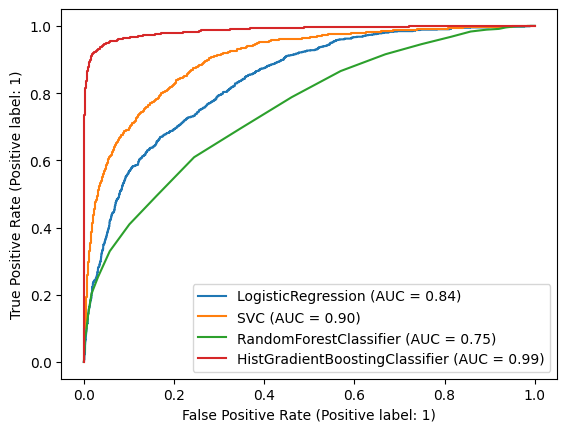

In [ ]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
import pickle
ax = plt.gca()
#hgb = clf4.best_estimator_
with open('reglin_bigdataset.pkl', 'rb') as fichier:
    reglin = pickle.load(fichier)
#reglin = clf1.best_estimator_

#with open('reglin_bigdataset.pkl', 'wb') as model_file:
#    pickle.dump(reglin, model_file)
reglin_disp = RocCurveDisplay.from_estimator(reglin,X_test,Y_test,ax=ax)

#svc = clf2.best_estimator_
with open('svc_bigdataset.pkl', 'rb') as fichier:
    svc = pickle.load(fichier)

svc_disp = RocCurveDisplay.from_estimator(svc,X_test,Y_test,ax=ax)

#with open('random_forest_bigdataset.pkl', 'rb') as fichier:
    #rf_model = pickle.load(fichier)

#rf_model = clf3.best_estimator_
with open('random_forest_bigdataset.pkl', 'rb') as model_file:
    rf_model = pickle.load(model_file)

rf_disp = RocCurveDisplay.from_estimator(rf_model,X_test,Y_test,ax=ax)

#hgb = clf4.best_estimator_
with open('hgb_bigdataset.pkl', 'rb') as fichier:
    hgb = pickle.load(fichier)

#hgb = clf4.best_estimator_
#with open('hgb_bigdataset.pkl', 'rb') as hgbfile:
#    pickle.dump(hgb, hgbfile)
hgb_disp = RocCurveDisplay.from_estimator(hgb,X_test,Y_test,ax=ax)


In [ ]:
from sklearn.metrics import confusion_matrix,roc_auc_score
from sklearn.metrics import classification_report
target_names = ['Humain','IA']
hgb = clf4.best_estimator_
print(classification_report(Y_test, hgb.predict(X_test), target_names=target_names))
print(confusion_matrix(Y_test, hgb.predict(X_test)))
print(f"AUC: {roc_auc_score(Y_test,hgb.predict_proba(X_test)[:,1])}")

              precision    recall  f1-score   support

      Humain       0.97      0.99      0.98      4275
          IA       0.97      0.86      0.91       901

    accuracy                           0.97      5176
   macro avg       0.97      0.93      0.95      5176
weighted avg       0.97      0.97      0.97      5176

[[4247   28]
 [ 125  776]]
AUC: 0.9863678433968754


##Inférence

In [ ]:
import pickle
import numpy
embedding_model = fasttext.load_model('fasttext.bin')
with open('hgb_bigdataset.pkl', 'rb') as fichier:
    best_model = pickle.load(fichier)

def get_vect(word):
    try:
      return embedding_model.get_word_vector(word)
    except KeyError:
        return numpy.zeros((embedding_model.vector_size,))

def sum_vectors(phrase):
    return sum(get_vect(w) for w in phrase)/len(phrase)

def infer(prompt):
  new_prompt = clean(prompt)
  X = sum_vectors(new_prompt).reshape(1,-1)
  proba = best_model.predict_proba(X)
  return proba
tdata = pd.read_csv("./Data/ai_generated_train_essays.csv")
tdata.head(20)
text = str(tdata['text'][19])
#text = ""
infer(text)

array([[4.66996368e-04, 9.99533004e-01]])